# Multiclass Text Classification on Consumer Complaints for Financial Products with Multinomial Naive Bayes and Linear Support Vector Machines
### Author: Georgios Spyrou (georgios.spyrou1@gmail.com)
### Completion Date: 30/08/2020



## Sections

- <a href='#Introduction' style="text-decoration: none">Introduction </a> 
- <a href='#Data_Loading' style="text-decoration: none">Data Loading</a> 
- <a href='#data_cleaning_eda' style="text-decoration: none">Data Cleaning & Exporatory Data Analysis (EDA)</a>
  - <a href='#initial_data_cleaning' style="text-decoration: none">Initial Data Cleaning</a>
  - <a href='#eda_and_viz' style="text-decoration: none">EDA & Visualizations</a> 
- <a href='#data_preprocessing' style="text-decoration: none">Data Preprocessing</a> 
- <a href='#model_creation' style="text-decoration: none">Model Creation and Evaluation</a> 
  - <a href='#multinomial_nb' style="text-decoration: none">Multinomial Naive Bayes Classifier</a>
  - <a href='#linear_svc' style="text-decoration: none">Linear Support Vector Machine Classifier</a> 

<a id='Introduction'></a>
## Introduction

The data used in this project contain complaints that have been made by consumers regarding financial services and products (e.g. student loans, credit reports, mortgage, etc) in the United States between November 2011 and May 2019. Each of the complaints is marked to belong under one Product Category. This makes the data ideal for supervised learning purposes, with the text (complaint from the consumer) as the **input**, and the category that the complaint belongs to as the **target** variable.

Predicting the correct category that a complaint belongs to can be very beneficial for the financial institutions (companies) that have to deal with responding to hundreds of complaints per day. If the customer who is filling the complaint does not submit it under the correct category, then that becomes a cost for the financial institution as -usually- they will have to:

- 1. Identify that a complaint is under the wrong category in the first place, which is something that happens only after someone has already spent time with the case 
- 2. Re-classify and redirect the complaint to the correct category and the appropriate personnel for further examination. 

Therefore, it's straighforward to understand the importance of an automated system that can identify the complaint category by looking at the compaint itself (input from the client), and automatically forward the case to the team responsible for this "group" of complaints. In this project, we will attempt to create models that could offer the above functionality and evaluate their performance, so that we can answer the question: _Would it worth it for a company to integrate a system like this into their main processes ?_

Finally, the dataset for this project is publicly available and it's getting updated daily from the USA Consumer Financial Protection Bureau. The latest version can be found <a href="https://catalog.data.gov/dataset/consumer-complaint-database" style="text-decoration: none"> here</a>.

After this quick introduction, we can move to the main part of the project. At the beggining we will load the dataset, perform any necessary data cleaning operations and continue with the exploratory data analysis part, so that we can get a better understanding of the dataset. After we make sure that we understand the data, we will proceed to the modeling part where we are going to create different types of classification algorithms and compare their performance on predicting the category to which each complaint should fall into.

<a id='Data_Loading'></a>
## Part 1 - Data Loading

We can start by importing the necessary python packages, setup the project directory and load the dataset so we can get a better understanding of the data format.

In [4]:
# Import dependencies
import os
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
init_notebook_mode(connected=True)

# NLP
import string 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocessing & Model Preparation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Performance Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [5]:
# Set up project folder
project_dir = r'D:\GitHub\Projects\Consumer_Complaints'
os.chdir(project_dir)

complaints_df = pd.read_csv(os.path.join(project_dir, 'Data', 'complaints.csv'))

In [6]:
print(f'The dataset has {complaints_df.shape[0]} rows and {complaints_df.shape[1]} columns(features).')

The dataset has 1706612 rows and 18 columns(features).


In [7]:
complaints_df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [8]:
complaints_df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


From the features contained in the dataset we technically only care about the columns **Consumer complaint narrative** which corresponds to the text/complaint of the consumer, and the **Product** which is the category that the complaint falls into and it will be our target variable. Please note that the input variable is going to be renamed in the next step, for ease of use.

<a id='data_cleaning_eda'> </a>
## Part 2 - Data Cleaning & Exporatory Data Analysis

<a id='initial_data_cleaning'> </a>
### Initial Data Cleaning

In [9]:
# Renaming the predictor column for ease of use
complaints_df.rename(columns={'Consumer complaint narrative': 'Complaint'}, inplace=True)

In [10]:
# Get the year that the complaint took place as a separate column
complaints_df['Year'] = complaints_df['Date received'].apply(lambda x: int(re.findall('[0-9]{4}', x)[0]))
    
complaints_df.Year.value_counts()

2019    277389
2018    257312
2017    242965
2020    232834
2016    191468
2015    168475
2014    153043
2013    108217
2012     72373
2011      2536
Name: Year, dtype: int64

In [11]:
# Identify how many missing values we have per column 
complaints_df.isnull().sum(axis=0)

Date received                         0
Product                               0
Sub-product                      235165
Issue                                 1
Sub-issue                        578864
Complaint                       1130110
Company public response         1028312
Company                               0
State                             29187
ZIP code                         164485
Tags                            1478326
Consumer consent provided?       648327
Submitted via                         0
Date sent to company                  0
Company response to consumer          2
Timely response?                      0
Consumer disputed?               938135
Complaint ID                          0
Year                                  0
dtype: int64

We can see that 1130110 out of the 1706612 complaints in the dataset are empty, which means that the consumer did not provide any text explaining the reason for raising the complaint. Thus, such cases are not very useful in our project as they provide no helpful information in order to predict to which product category they should belong based on the consumer's input.

Before we reduce the dataset to only retain the rows where the Complaint field is populated, we will continue the EDA with the whole dataset and perform this task in a later stage.

<a id='eda_and_viz'> </a>
### Exploratory Data Analysis & Visualizations

In [12]:
def plotNumberOfObservationsPerCategory(input_df: pd.core.frame.DataFrame, col: str, by_year=True, figsize=(10,8)):
    """
    Returns a countplot with the number of observations
    based on the column defined by 'col'
    """
    hue = None
    if by_year == True:
        hue = input_df['Year']
    plt.figure(figsize=figsize)
    sns.countplot(y=input_df[col], hue=hue,
                       order=input_df[col].value_counts().index)
    plt.ylabel('Complaint Category', fontweight='bold')
    plt.title(f'Number of Complaints per {col} Category', fontweight="bold")
    plt.show()

At first we can have a look at the distribution of complaints from the full dataset, compared to the category that they belong:

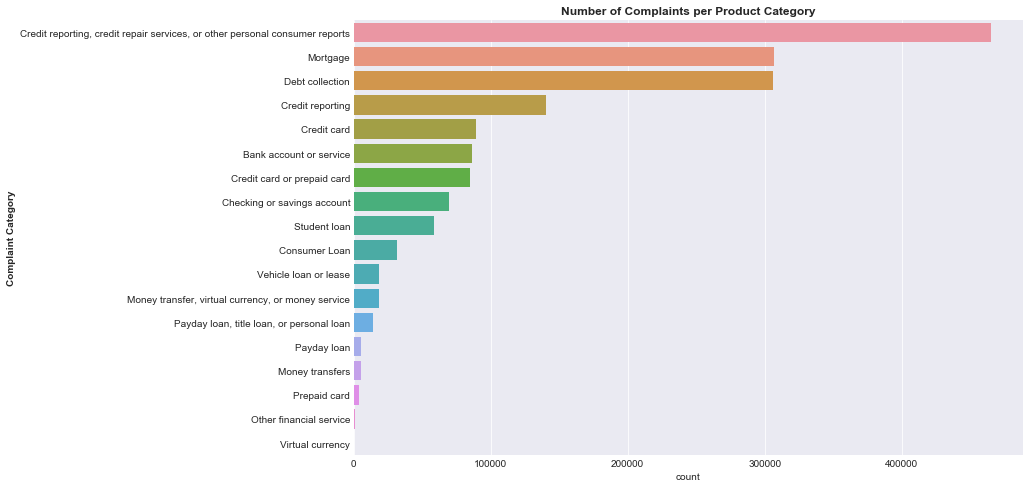

In [13]:
plotNumberOfObservationsPerCategory(complaints_df, col='Product', by_year=False, figsize=(12,8))

We can see that there are many cases where a category is overlapping with another. For example, we have both 'Credit card or prepaid card' and 'Credit card' as separate categories. Therefore we will merge such cases of categories that are overlapping, and we will end up with 12 Categories instead of 18 that were present in the initial dataset.

In [14]:
complaints_processed = complaints_df

prod_category_map = {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
                     'Credit card': 'Credit card or prepaid card',
                     'Payday loan': 'Payday loan, title loan, or personal loan',
                     'Prepaid card': 'Credit card or prepaid card',
                     'Money transfers': 'Money transfer, virtual currency, or money service',
                     'Virtual currency': 'Money transfer, virtual currency, or money service'}

complaints_processed['Product'].replace(prod_category_map, inplace=True)

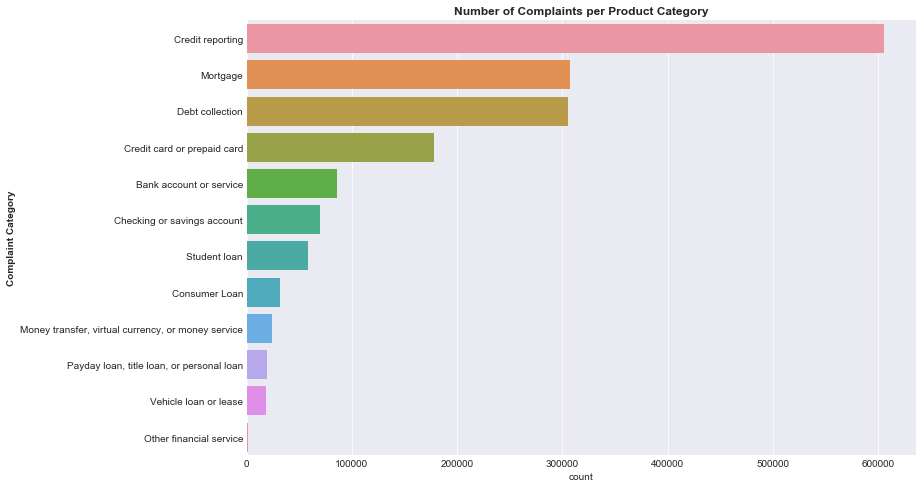

In [15]:
plotNumberOfObservationsPerCategory(complaints_processed, col='Product', by_year=False, figsize=(12,8))

Furthermore, we can observe that the initial dataset has some **imbalance** in terms of the categories of the complaints. Appears that the most regular complaints are related to credit reporting, mortage and debt collection. This imbalance of the target variable can cause misleading results when evaluating the machine learning algorithms that we will use later in the project, thus we will have to be careful with what evaluation metric we are going to use to compare the models.

In [16]:
def plotTopComplaints(input_df: pd.core.frame.DataFrame, agg_col: str, top_n: int, bottom=False, figsize=(10,8)):
    """
    Aggregate a dataframe based on column of interest and calcualte the number
    of observations per aggregated group.
    
    The function returns a barplot object showing the results of the above
    calculation.

    Args:
    ----
    agg_col: Name of the column that we want to base the aggregation
    top_n: Amount of observations to be included in the plot
    bottom: Plot the top-n from the top (highest) or from the bottom (lowest)
    """
    size = float(input_df.shape[0])
    rot = 0
    
    if (agg_col=='Company') & (top_n >=10):
        rot = 45

    try:
        most_cmplts = input_df[['Complaint ID',
                            agg_col]].groupby([agg_col]).agg(['count'])
    
        most_cmplts = most_cmplts.sort_values(
                by=[('Complaint ID','count')], ascending=bottom)

        plt.figure(figsize=figsize)
        ax = sns.barplot(x=most_cmplts.index[0:top_n], y=('Complaint ID',
                         'count'), data=most_cmplts[0:top_n])
            
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2., height + 4, '{:1.2f}%'.format(
                    100 * height/size), ha="center")

        ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
        plt.ylabel('Number of complaints', fontweight='bold')
        plt.title(f'{agg_col} with the most number of complaints',
                  fontweight='bold')
        plt.show()
    except KeyError:
        print('agg_col does not correspond to a column that exists')

Now we can continue with the EDA. At first, we will identify the states that most complaints have been submitted to:

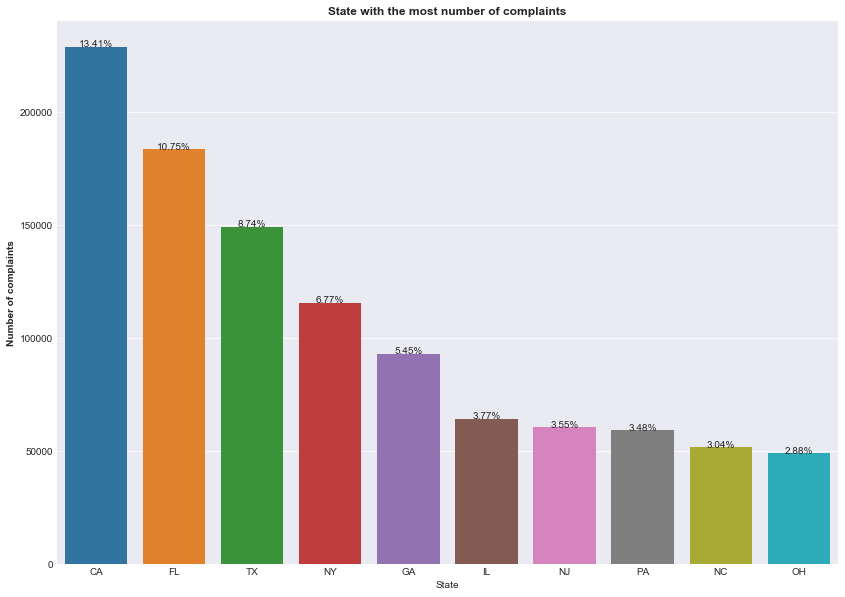

In [17]:
# Barplot
plotTopComplaints(complaints_processed, agg_col='State', top_n=10, bottom=False, figsize=(14,10))

# Map
most_cmplts = complaints_processed[['Complaint ID','State']].groupby(['State']).agg(['count'])
most_cmplts = most_cmplts.sort_values(by=[('Complaint ID','count')], ascending=False)
most_cmplts.reset_index(level=0, inplace=True)

most_cmplts['Text'] = 'State Code: ' + most_cmplts['State'] + '<br>'

data = [ dict(
        type='choropleth',
        colorscale = 'RdBu',
        autocolorscale = False,
        reversescale = True,
        locations = most_cmplts['State'],
        z = most_cmplts[('Complaint ID','count')], 
        locationmode = 'USA-states',
        text = most_cmplts['Text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "# of complaints")
        ) ]

layout = dict(
    title = 'Number of Complaints by State',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='usa-cloropleth-map-by-state')

We can see that only 5 States (California, Florida, Texas, New York and Georgia) account for more that 40% of the total complaints.

Find companies that received the most complaints from their consumers:

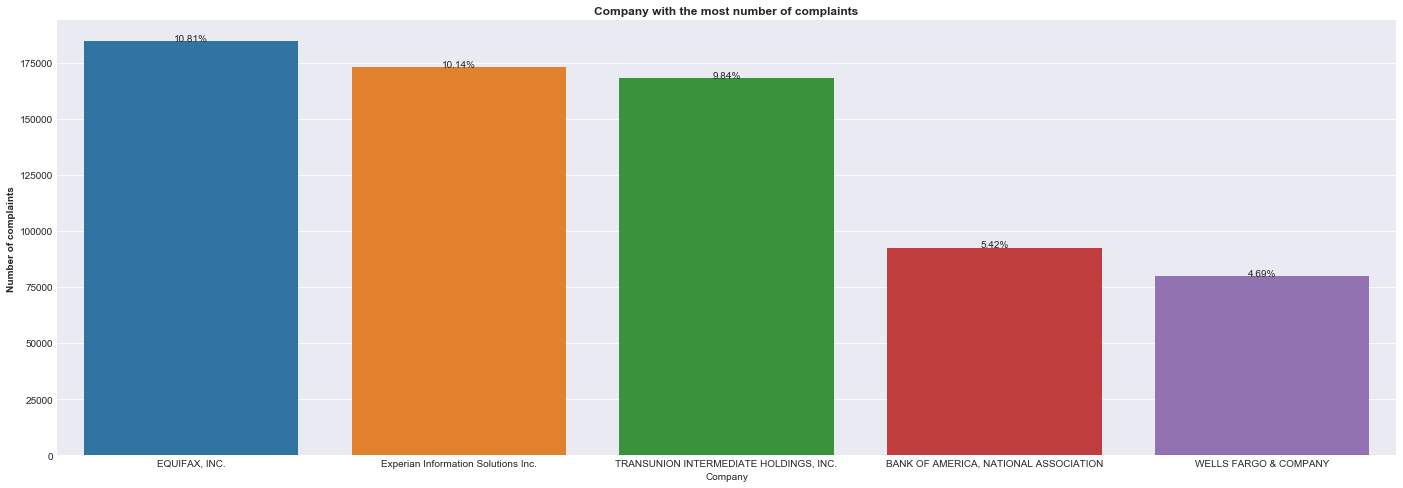

In [18]:
plotTopComplaints(complaints_processed, agg_col='Company', top_n=5, bottom=False, figsize=(24,8))

Similarly, the first 5 Companies presented above seem to receive around 40% of the overall amount of complaints.

Now, before we move to the data preprocessing step and the development of the machine learning algorithms we need to make sure to take into account what we mentioned earlier regarding the Complaint column. As a reminder, only 576502 cases out of the 1706612 from the original dataset were populated. Thus, we will have to reduce our data to retain only the cases for which the text/complaint of the consumer towards the financial institution is known. This is necessary as our project is focused on supervised learning algorithms and it's mandatory to know the both the input (complaint) and the target (Category) variables before we fit them into the model.

In [19]:
# Filter the dataset to retain only the rows for which the 'Consumer complaint narrative' column is populated
complaints_processed = complaints_processed[complaints_processed['Complaint'].notnull()]
complaints_processed.shape

(576502, 19)

In [20]:
relevant_cols = ['Year', 'Complaint', 'Product']
complaints_processed = complaints_processed[relevant_cols]

complaints_processed.shape
complaints_processed.isnull().sum(axis=0)

Year         0
Complaint    0
Product      0
dtype: int64

<a id='data_preprocessing'> </a>
## Part 3 - Data Preprocessing

Before creating the classifiers in order to predict the Product category that a specific complaint should fall into, we will have to deal with the fact the the input to our algorithms (Complaint) has a text format. 

At first, we will perform the regular text cleaning operations that you are likely to see in any Natural Language Processing task. This includes the creation of tokens (i.e. split each complaint into separate words) and the removal of stopwords, punctuation and numbers from the text, as this information does not offer much into predicting the correct Product category. Finally, we will perform a lemmatization task with which we will convert the words to their base form.

**Step 1.** Tokenize a sentence into separate words, and filter out words that are stopwords, punctuation, numbers or have the form 'XXX' which indicates classified data.

In [21]:
def tokenize_sentence(sentence: str, rm_stopwords=True, rm_punctuation=True, rm_numbers=True, rm_classified=True) -> list:
    """
    Tokenize a given string, and return the words as a list.
    The function offers functionality to exclude the words that are either
    1) a stopword 2) punctuation symbol 3) a number or 4) has the format 'XX'
    or 'XXXX' indicates that a word is classified.
    """
    tokenized = [x.lower() for x in word_tokenize(sentence)]
    
    
    if rm_classified == True:
        tokenized = [x for x in tokenized if x.lower() != 'xxxx' and
                    x.lower() != 'xx' and x.lower() != 'xx/xx/xxxx']
    
    if rm_stopwords == True:
        tokenized = [x for x in tokenized if x not in stop_words]
     
    if rm_punctuation == True:
        tokenized = [x for x in tokenized if x not in string.punctuation]
    
    if rm_numbers == True:
        tokenized = [x for x in tokenized if not x.isdigit()]
        
    return tokenized

In [ ]:
stop_words = set(stopwords.words('english')) 

complaints_processed['Complaint_Tokenized'] = complaints_processed.apply(lambda x: tokenize_sentence(x['Complaint'],
                                             rm_stopwords=True, rm_punctuation=True, rm_numbers=True, rm_classified=True),
                                             axis=1)

**Step 2.** Lemmatize the remaining words left from Step 1

In [ ]:
def lemmatize_sentence(sentence, return_form = 'string'):
    """
    Lemmatize a given string . 
    
    Input:
    ------
        sentence: 
            Sentence that we want to lemmatize each word. The input can be
            of the form of tokens (list) or the complete sentence (string).
        return_form: 
            Format of the return function. Can be either a string
            with the concatenated lemmatized words or a list of the 
            lemmatized words.
    Returns:
    -------
        If join_string = True then the function returns the
        lemmatized words as a sentence. Else it returns the words as a list.
    """
    # Handle the case where the input is the string without being tokenized
    if type(sentence) != list:
        sentence = re.findall(r"[\w']+|[.,!?;]", sentence)

    lemmatizer = WordNetLemmatizer()
    if return_form == 'string':
        return ' '.join([lemmatizer.lemmatize(word) for word in sentence])
    else:
        return [lemmatizer.lemmatize(word) for word in sentence]

In [ ]:
complaints_processed['Complaint_Clean'] = complaints_processed.apply(lambda x: lemmatize_sentence(x['Complaint_Tokenized'],
                           return_form='string'), axis=1)

In [ ]:
# Pickle the file so we do not need to reprocess each time
pickle_processed_df_filename = 'complaints_processed.pkl'
pickled_file_loc = os.path.join(project_dir, 'Data', pickle_processed_df_filename)

complaints_processed.to_pickle(pickled_file_loc)

In [ ]:
complaints_processed = pd.read_pickle(pickled_file_loc)

**Step 3.** Finally, we should transform the Product categories into distinct integer values representing the initial categorical values.

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

complaints_processed['Product_Id'] = label_encoder.fit_transform(complaints_processed['Product'])

In [27]:
# Also its good to have the categories as a dictionary
product_map = complaints_processed.set_index('Product_Id').to_dict()['Product']
product_map

{0: 'Bank account or service',
 1: 'Checking or savings account',
 2: 'Consumer Loan',
 3: 'Credit card or prepaid card',
 4: 'Credit reporting',
 5: 'Debt collection',
 6: 'Money transfer, virtual currency, or money service',
 7: 'Mortgage',
 8: 'Other financial service',
 9: 'Payday loan, title loan, or personal loan',
 10: 'Student loan',
 11: 'Vehicle loan or lease'}

After performing the aforementioned preprocessing steps, we can have a look at our final dataframe so we can get a better understanding of what we have done till now. Note that the two columns that we will use in the machine learning models will be the **Complaint_Clean** and the **Product_Id**.

In [28]:
complaints_processed.head(10)

,Year,Complaint,Product,Complaint_Tokenized,Complaint_Clean,Product_Id
0,2019,transworld systems inc. \nis trying to collect...,Debt collection,"[transworld, systems, inc., trying, collect, d...",transworld system inc. trying collect debt min...,5
2,2019,I would like to request the suppression of the...,Credit reporting,"[would, like, request, suppression, following,...",would like request suppression following item ...,4
3,2019,"Over the past 2 weeks, I have been receiving e...",Debt collection,"[past, weeks, receiving, excessive, amounts, t...",past week receiving excessive amount telephone...,5
7,2019,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser...","[sold, access, event, digitally, screenshots, ...",sold access event digitally screenshots detail...,6
8,2019,This complaint dates back to last XX/XX/XXXX d...,Mortgage,"[complaint, dates, back, last, loan, modificat...",complaint date back last loan modification don...,7
9,2020,My credit has been compromised. I found out be...,Credit reporting,"[credit, compromised, found, sent, email, need...",credit compromised found sent email needed tak...,4
11,2019,Today XX/XX/XXXX went online to dispute the in...,Credit reporting,"[today, went, online, dispute, incorrect, pers...",today went online dispute incorrect personal i...,4
13,2019,XXXX is reporting incorrectly to Equifax and X...,Credit reporting,"[reporting, incorrectly, equifax, account, bal...",reporting incorrectly equifax account balance ...,4
14,2019,Please reverse the late payments reported on t...,Credit reporting,"[please, reverse, late, payments, reported, fo...",please reverse late payment reported following...,4
15,2020,I received an email from a XXXX XXXX along wit...,Debt collection,"[received, email, along, single, page, attache...",received email along single page attached emai...,5


<a id='model_creation'></a>
## Part 4 - Model Creation and Evaluation

Before we create the models, we have to split the dataset into training (80%) and test samples (20%).

In [29]:
X = complaints_processed['Complaint_Clean']
y = complaints_processed['Product_Id']

In [30]:
# Use the stratify parameter in order to split the target variabe (categories) evenly among train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

At this stage we have cleaned and preprocessed the dataset, and reformatted it in a way that will allow us to develop the prediction algorithms. Before we move to the next part, we have to summarize the steps that we need to take in order to successfully create well-behaved algorithms.

<a id='multinomial_nb'></a>
## Multinomial Naive Bayes Classifier

In [72]:
# Multinomial Naive Bayes model
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])

In [73]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
# 'TfIdf__min_df': [10, 20, 30],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [74]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [75]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 16.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('TfIdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...   vocabulary=None)), ('MultinomialNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'TfIdf__max_features': [4000, 5000, 6000], 'TfIdf__ngram_range': [(1, 1)], 'TfIdf__use_idf': [True], 'MultinomialNB__alpha': [0.01, 0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

We can see which hyperpatameter combination was the optimal for the Naive Bayes classifier:

In [76]:
grid_search_mnb.best_params_

{'MultinomialNB__alpha': 0.01,
 'TfIdf__max_features': 6000,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [77]:
grid_search_mnb.best_estimator_

Pipeline(memory=None,
     steps=[('TfIdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=6000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...  vocabulary=None)), ('MultinomialNB', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [78]:
# Check the score on the training and test sets
grid_search_mnb.score(X_test, y_test)

0.7825604287907304

In [79]:
predicted = grid_search_mnb.predict(X)
complaints_processed['Predicted_Category_MNB'] = predicted

In [80]:
# 7. Review performance

# Get the confusion matrix as dataframe
y_predicted = grid_search_mnb.predict(X_test)

In [81]:
def plotConfusionMatrixHeatmap(input_df: pd.core.frame.DataFrame, model_name: str, figsize=(20, 18)):
    """
    Return the results of a multiclass classification algorithms as a heatmap
    based on a confusion matrix.        
    """
    # Heatmap of the results
    plt.figure(figsize=figsize)
    sns.heatmap(input_df, annot=True, fmt='d', cmap='Reds')
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Confusion Matrix - {model_name}', size=14, fontweight='bold')
    plt.show()

In [82]:
key_to_product_names = [x[1] for x in sorted(product_map.items())]

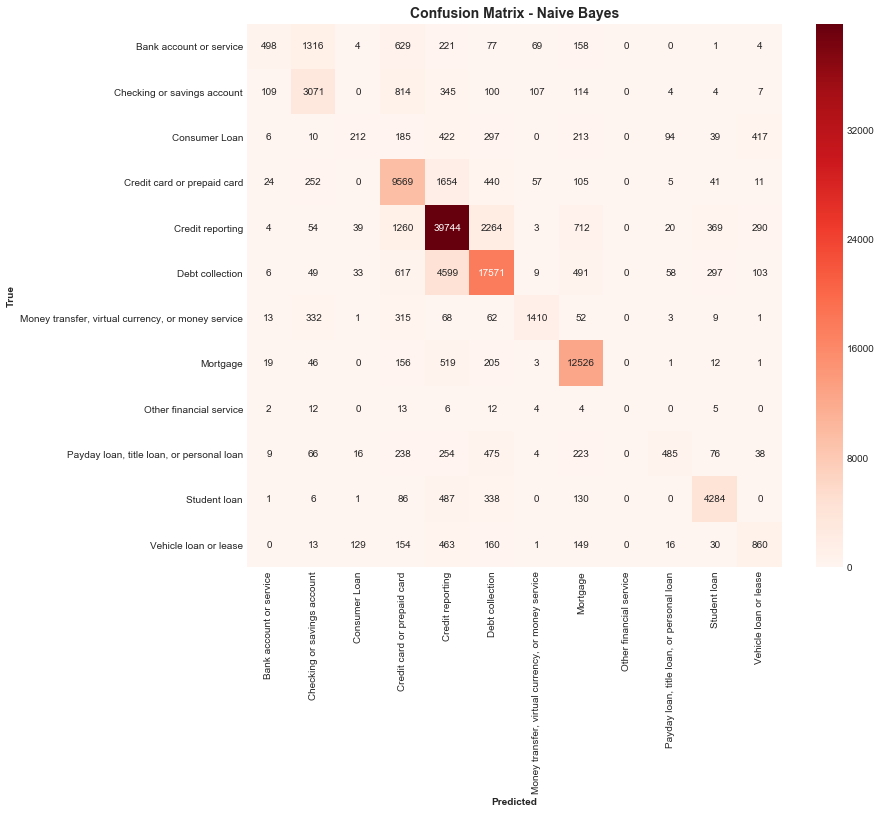

In [83]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_product_names, columns=key_to_product_names)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

In [84]:
classification_report_mnb = classification_report(y_test, y_predicted, target_names=key_to_product_names)
print(classification_report_mnb)

                                                    precision    recall  f1-score   support

                           Bank account or service       0.72      0.17      0.27      2977
                       Checking or savings account       0.59      0.66      0.62      4675
                                     Consumer Loan       0.49      0.11      0.18      1895
                       Credit card or prepaid card       0.68      0.79      0.73     12158
                                  Credit reporting       0.81      0.89      0.85     44759
                                   Debt collection       0.80      0.74      0.77     23833
Money transfer, virtual currency, or money service       0.85      0.62      0.72      2266
                                          Mortgage       0.84      0.93      0.88     13488
                           Other financial service       0.00      0.00      0.00        58
         Payday loan, title loan, or personal loan       0.71      0.26      0.

<a id='linear_svc'></a>
## Linear Support Vector Machine

In [119]:
pipeline_lsvm = Pipeline(steps= [('TfIdf', TfidfVectorizer()),
                                 ('SGDC', SGDClassifier())])

In [120]:
# Parameter grid for SVC
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [500, 1000, 2000, 3000],
# 'TfIdf__min_df': [10, 20, 30],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'SGDC__alpha' : [0.01, 0.05]
}

In [123]:
grid_search_svc = GridSearchCV(pipeline_lsvm, param_grid, cv=5, verbose=1, n_jobs=6)

In [124]:
grid_search_svc.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 20.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('TfIdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'TfIdf__max_features': [4000, 5000, 6000], 'TfIdf__ngram_range': [(1, 1)], 'TfIdf__use_idf': [True], 'SGDC__alpha': [0.01, 0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [125]:
grid_search_svc.best_params_

{'SGDC__alpha': 0.01,
 'TfIdf__max_features': 4000,
 'TfIdf__ngram_range': (1, 1),
 'TfIdf__use_idf': True}

In [126]:
# Check the score on the training and test sets
grid_search_svc.score(X_test, y_test)

0.6549813097891606

In [129]:
predicted = grid_search_svc.predict(X)
complaints_processed['Predicted_Category_LSVC'] = predicted

In [130]:
y_predicted = grid_search_svc.predict(X_test)

In [131]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_product_names, columns=key_to_product_names)

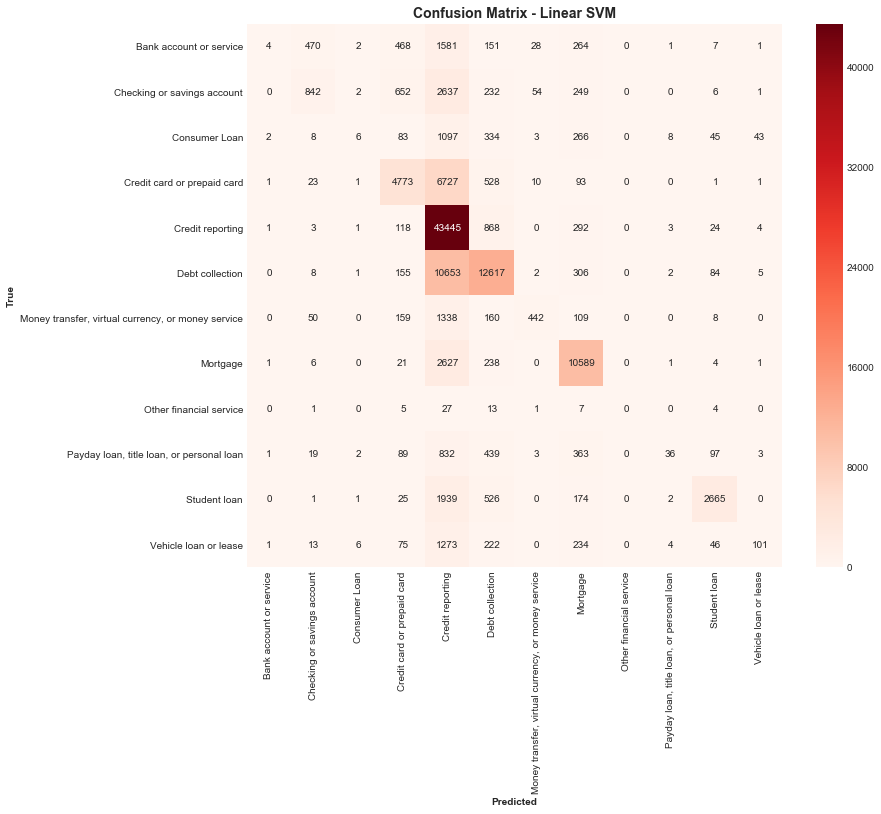

In [132]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Linear SVM', figsize=(12, 10))

In [133]:
classification_rep = classification_report(y_test, y_predicted,target_names=key_to_product_names)
print(classification_rep)

                                                    precision    recall  f1-score   support

                           Bank account or service       0.36      0.00      0.00      2977
                       Checking or savings account       0.58      0.18      0.28      4675
                                     Consumer Loan       0.27      0.00      0.01      1895
                       Credit card or prepaid card       0.72      0.39      0.51     12158
                                  Credit reporting       0.59      0.97      0.73     44759
                                   Debt collection       0.77      0.53      0.63     23833
Money transfer, virtual currency, or money service       0.81      0.20      0.31      2266
                                          Mortgage       0.82      0.79      0.80     13488
                           Other financial service       0.00      0.00      0.00        58
         Payday loan, title loan, or personal loan       0.63      0.02      0.